In [2]:
import numpy as np
import scipy
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import cvxpy as cvx
from scipy.stats import chisquare, f_oneway, ttest_ind
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import sklearn
from sklearn.model_selection import train_test_split
import shap
from IPython import display

#### Master Data, Transaction Data, Metadata

- Master Data is the Supplier Data
- Transaction Data is the Purchase Order Data
- Reference Data is the CPV Data
- Golden Records is the Master Data combined with Reference Data

### Golden Records

In [2]:
pendle_borough_data = pd.read_csv('dataset/extracts/pendle_borough_records_extracts.csv', encoding='latin1')
rochdale_borough_data = pd.read_csv('dataset/extracts/rochdale_borough_records_extracts.csv', encoding='latin1')
stockport_metropolitan_borough_data = pd.read_csv('dataset/extracts/stockport_metropolitan_borough_records_extracts.csv', encoding='latin1')

In [62]:
input_data_pendle = pendle_borough_data.loc[:, ['privilege', 'service_category', 'value']]
input_data_rochdale = rochdale_borough_data.loc[:, ['privilege', 'service_category', 'total_value']]
input_data_stockport = stockport_metropolitan_borough_data.loc[:, ['privilege', 'service_category', 'po_value']]
input_data_rochdale.columns.values[2] = 'value'
input_data_stockport.columns.values[2] = 'value'
input_data = input_data_pendle.append(input_data_rochdale, ignore_index=True).append(input_data_stockport, ignore_index=True)
input_data = input_data.groupby(by=['privilege', 'service_category']).sum()
privilege_data = input_data.groupby(by=['privilege']).sum()
service_data = input_data.groupby(by=['service_category']).sum()
privilege_data.columns.values[0] = 'privilege_value'
service_data.columns.values[0] = 'service_values'
input_data_new = input_data.join(privilege_data, on='privilege', how='left')
input_data_new = input_data_new.join(service_data, on='service_category', how='left')
y = np.array(input_data_new.index.values.tolist())
input_data_new['privilege'] = y[:,0]
input_data_new['service_category'] = y[:,1]
input_data_new

value  privilege_value  service_values  \
privilege      service_category                                               
Administration economy            15100.00        175715.13      1070636.70   
               education          10999.40        175715.13      2846407.25   
               environment       115288.73        175715.13     22145946.21   
               health              5423.00        175715.13     26411057.86   
               member             28904.00        175715.13        49834.00   
...                                    ...              ...             ...   
Utility        data                8300.00        374170.82       160232.90   
               education          29400.00        374170.82      2846407.25   
               environment       166470.82        374170.82     22145946.21   
               member              9000.00        374170.82        49834.00   
               misc              161000.00        374170.82      3087842.21   

                                      privilege service_category  
privilege      service_category                                   
Administration economy           Administration          economy  
               education         Administration        education  
               environment       Administration      environment  
               health            Administration           health  
               member            Administration           member  
...                                         ...              ...  
Utility        data                     Utility             data  
               education                Utility        education  
               environment              Utility      environment  
               member                   Utility           member  
               misc                     Utility             misc  

[112 rows x 5 columns]

### Evaluating the economy, the first step: Instance Based

**Explain AI Using:**
- Structural Type Records (originating from Clustering)
- Behavioural Type Records (originating from Prior-Posterior)

In [63]:
s = cvx.Variable(input_data_new.loc[:,'service_values'].values.shape[0])
p = cvx.Variable(input_data_new.loc[:,'privilege_value'].values.shape[0])

service = cvx.matmul(s, input_data_new.loc[:,'service_values'].values)
privilege = cvx.matmul(p, input_data_new.loc[:,'privilege_value'].values)

# SPECTRUM
GAMMA_SHAPE=5e1
GAMMA_SCALE=1e25
NORMAL_CENTER=1e20
NORMAL_STD=5e19

dmu_s = input_data_new.loc[:, ['value', 'service_values', 'service_category']]
dmu_p = input_data_new.loc[:, ['value', 'privilege_value', 'privilege']]

dmu_s = pd.get_dummies(dmu_s)
dmu_p = pd.get_dummies(dmu_p)

# padding
dmu_s = np.concatenate([dmu_s.values, np.zeros((dmu_s.values.shape[0],dmu_p.values.shape[1]-dmu_s.shape[1]))],axis=1)
dmu_s /= (np.sum(np.square(dmu_s),axis=0)+1e-4)
dmu_p = dmu_p.values
dmu_p /= (np.sum(np.square(dmu_p),axis=0)+1e-4)

# objective function
objective = cvx.Maximize(service)

# constraints
constraints = [cvx.matmul(s, dmu_s) - cvx.matmul(p, dmu_p) <= 0, privilege == 1, s >= 0, p >= 0]

# use cvxpy to solve the objective
problem = cvx.Problem(objective, constraints).solve(verbose=False, solver=cvx.SCS, max_iters=500)

# overall
print(f_oneway(privilege_data.values[:,0], service_data.values[:,0]))
print(ttest_ind(privilege_data.values[:,0], service_data.values[:,0]))

# single exposure
print(chisquare(input_data_new.loc[:,'value'].values/input_data_new.loc[:,'value'].values.max(), 
    input_data_new.loc[:,'service_values'].values/input_data_new.loc[:,'service_values'].values.max()))

print(chisquare(input_data_new.loc[:,'value'].values/input_data_new.loc[:,'value'].values.max(), 
    input_data_new.loc[:,'privilege_value'].values/input_data_new.loc[:,'privilege_value'].values.max()))

F_onewayResult(statistic=2.3243373951594823, pvalue=0.13689184061066684)
Ttest_indResult(statistic=-1.5245777760283281, pvalue=0.1368918406106668)
Power_divergenceResult(statistic=40.31470065970221, pvalue=0.9999999999284775)
Power_divergenceResult(statistic=23.061425648886974, pvalue=1.0)


Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.


**Looking at the data:**

In [65]:
service_data.index, privilege_data.index

(Index(['business', 'data', 'economy', 'education', 'environment', 'expense',
        'finance', 'health', 'maintenance', 'member', 'misc'],
       dtype='object', name='service_category'),
 Index(['Administration', 'Buildings', 'Consumer Products', 'Data',
        'Development', 'Education', 'Entertainment', 'Environment', 'Equipment',
        'Food', 'Health', 'Insurance', 'Legal', 'Material', 'Material Handling',
        'Media', 'Medical', 'Paper', 'Products', 'Social', 'State', 'Textile',
        'Transport', 'Utility'],
       dtype='object', name='privilege'))

### Adding Weights to the Golden Records to understand the Workflow

**Explain AI using:**

- Business Drivers (by Decision Trees)
- Ultimate Goals (by SHAP)

In [5]:
privilege_data.columns.values[0] = 'privilege_value'
service_data.columns.values[0] = 'service_values'
input_data_new = input_data.join(privilege_data, on='privilege', how='left')
input_data_new = input_data_new.join(service_data, on='service_category', how='left')
input_data_new['privilege_weights'] = p.value
input_data_new['service_weights'] = s.value
y = np.array(input_data_new.index.values.tolist())
input_data_new['privilege'] = y[:,0]
input_data_new['service_category'] = y[:,1]
input_data_new

value  privilege_value  service_values  \
privilege      service_category                                               
Administration economy            15100.00        175715.13      1070636.70   
               education          10999.40        175715.13      2846407.25   
               environment       115288.73        175715.13     22145946.21   
               health              5423.00        175715.13     26411057.86   
               member             28904.00        175715.13        49834.00   
...                                    ...              ...             ...   
Utility        data                8300.00        374170.82       160232.90   
               education          29400.00        374170.82      2846407.25   
               environment       166470.82        374170.82     22145946.21   
               member              9000.00        374170.82        49834.00   
               misc              161000.00        374170.82      3087842.21   

                                 privilege_weights  service_weights  \
privilege      service_category                                       
Administration economy               -4.827787e-13     2.037658e-10   
               education             -4.845244e-13     2.052770e-10   
               environment           -4.401264e-13     1.388840e-09   
               health                -4.868984e-13     4.149560e-08   
               member                -4.769020e-13    -2.816498e-11   
...                                            ...              ...   
Utility        data                  -1.779070e-14     4.693538e-11   
               education             -1.473525e-14     1.780219e-10   
               environment            5.113725e-15     1.313029e-09   
               member                -1.768933e-14     1.316955e-12   
               misc                   4.321506e-15     1.420530e-10   

                                      privilege service_category  
privilege      service_category                                   
Administration economy           Administration          economy  
               education         Administration        education  
               environment       Administration      environment  
               health            Administration           health  
               member            Administration           member  
...                                         ...              ...  
Utility        data                     Utility             data  
               education                Utility        education  
               environment              Utility      environment  
               member                   Utility           member  
               misc                     Utility             misc  

[112 rows x 7 columns]

### Golden Records have been transformed to Normalised Form

**Service Model**

In [6]:
X = pd.get_dummies(input_data_new.drop(columns=['privilege', 'service_category']))
y = input_data_new.loc[:, ['service_category']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dtree = sklearn.tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree.score(X_test, y_test)

1.0

### SHAP Feature Importance Table

**Explaining AI using:**

- Feature Extraction and Feature Mapping (SHAP Importance)

In [16]:
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X)

In [40]:
shap.initjs()

In [45]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [44]:
shap.force_plot(explainer.expected_value[1], shap_values[1])

In [43]:
shap.force_plot(explainer.expected_value[2], shap_values[2])

In [28]:
X.iloc[[0,6,12,19,28,63],:]

,,value,privilege_value,service_values,privilege_weights,service_weights
privilege,service_category,,,,,
Administration,economy,15100.0,175715.13,1070636.7,-4.827787e-13,2.037658e-10
Buildings,economy,5950.0,3462611.18,1070636.7,-1.027022e-14,2.173189e-10
Consumer Products,economy,15161.4,706247.15,1070636.7,-4.884176e-14,2.036749e-10
Data,economy,8082.3,16214463.71,1070636.7,-2.294303e-15,2.141605e-10
Development,economy,22210.0,1249044.60,1070636.7,-8.348683e-14,1.932344e-10
Legal,economy,1004133.0,14515053.97,1070636.7,-2.431476e-16,-1.261196e-09


In [42]:
shap.force_plot(explainer.expected_value[3], shap_values[3])

In [41]:
shap.force_plot(explainer.expected_value[4], shap_values[4])

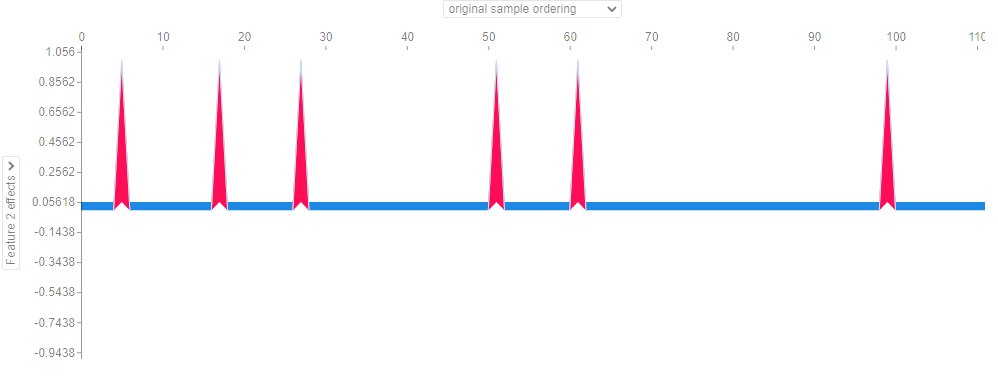

In [6]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image1.png")

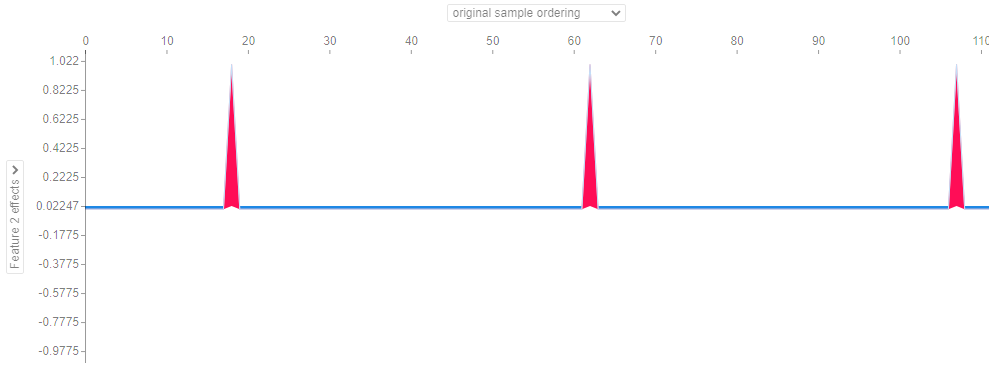

In [7]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image2.png")

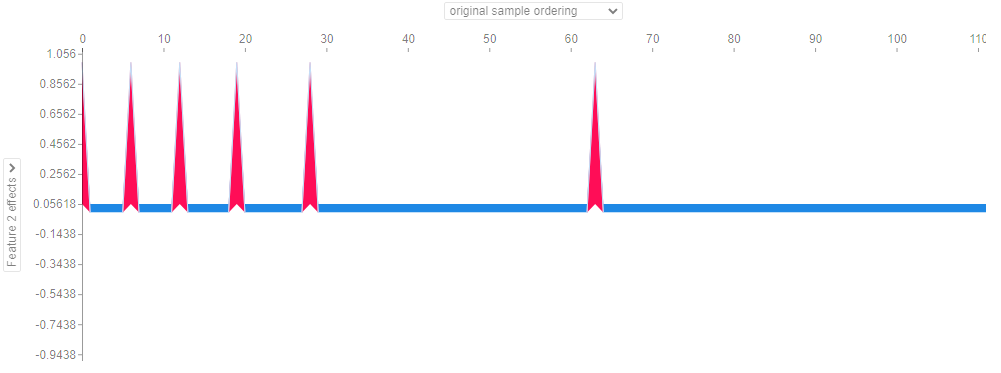

In [8]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image3.png")

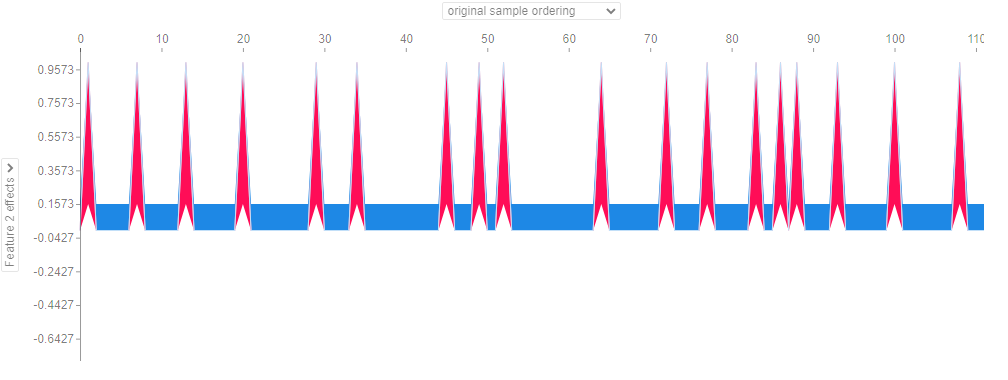

In [9]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image4.png")

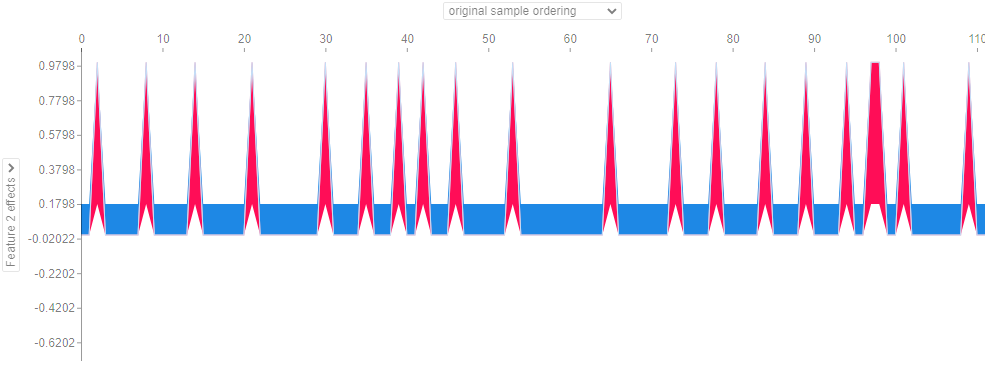

In [10]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image5.png")

**Result:**

# **It clearly indicates**

**High Importance: Data on Privilege and Legal after that**

**Process: Service Based Maximisation**

**Analysis: Instance Based**

---------------------------------------------------------------------------------------------------------------------------

### Evaluating the economy, the second step: Group Based

**Explain AI Using:**
- Structural Type Records (originating from Clustering)
- Behavioural Type Records (originating from Prior-Posterior)

In [58]:
s = cvx.Variable(service_data.values.shape[0])
p = cvx.Variable(privilege_data.values.shape[0])

service = cvx.matmul(s, service_data.values[:,0])
privilege = cvx.matmul(p, privilege_data.values[:,0])

# SPECTRUM
NORMAL_CENTER=1e30
NORMAL_STD=10

# equalize the DMUs
dmu_s = np.random.normal(NORMAL_CENTER, NORMAL_STD, service_data.values.shape[0])
dmu_p = np.random.normal(NORMAL_CENTER, NORMAL_STD, privilege_data.values.shape[0])

# objective function
objective = cvx.Maximize(service)

# constraints
constraints = [cvx.matmul(s, dmu_s) - cvx.matmul(p, dmu_p) <= 0, privilege == 1, s >= 0, p >= 0]

# use cvxpy to solve the objective
problem = cvx.Problem(objective, constraints).solve(verbose=False, solver=cvx.SCS, max_iters=500)

print(f_oneway(privilege_data.values[:,0], service_data.values[:,0]))
print(ttest_ind(privilege_data.values[:,0], service_data.values[:,0]))
print(chisquare(dmu_s/dmu_s.max(), service_data.values[:,0]/service_data.values.max()))

print(chisquare(dmu_p/dmu_p.max(), privilege_data.values[:,0]/privilege_data.values.max()))

F_onewayResult(statistic=2.3243373951594823, pvalue=0.13689184061066684)
Ttest_indResult(statistic=-1.5245777760283281, pvalue=0.1368918406106668)
Power_divergenceResult(statistic=813.7076144637392, pvalue=2.330553810828538e-168)
Power_divergenceResult(statistic=3225.735687795859, pvalue=0.0)


In [56]:
service_data.index, privilege_data.index

(Index(['business', 'data', 'economy', 'education', 'environment', 'expense',
        'finance', 'health', 'maintenance', 'member', 'misc'],
       dtype='object', name='service_category'),
 Index(['Administration', 'Buildings', 'Consumer Products', 'Data',
        'Development', 'Education', 'Entertainment', 'Environment', 'Equipment',
        'Food', 'Health', 'Insurance', 'Legal', 'Material', 'Material Handling',
        'Media', 'Medical', 'Paper', 'Products', 'Social', 'State', 'Textile',
        'Transport', 'Utility'],
       dtype='object', name='privilege'))

In [59]:
s.value, p.value

(array([3.89829622e-07, 8.92953112e-14, 3.60742609e-08, 1.76542204e-07,
        1.70318456e-06, 6.96419149e-14, 4.33988580e-07, 2.04056569e-06,
        1.17121573e-06, 1.05397170e-13, 1.95640320e-07]),
 array([4.89433759e-07, 2.55480097e-12, 4.81755774e-09, 1.23783538e-11,
        8.49551630e-13, 5.61491890e-13, 6.18121062e-07, 2.89393095e-07,
        4.82593601e-07, 6.11047299e-07, 1.67504076e-11, 5.13031228e-13,
        1.10691917e-11, 4.24177325e-07, 1.08527359e-11, 3.79498002e-12,
        4.61150898e-07, 5.32177242e-07, 6.02618957e-07, 3.88989644e-07,
        6.22037155e-07, 3.12269500e-07, 1.12170247e-12, 3.08153763e-07]))

In [29]:
privilege_data['privilege_weights'] = p.value
service_data['service_weights'] = s.value
privilege_data.columns.values[0] = 'privilege_value'
service_data.columns.values[0] = 'service_values'
input_data_new = input_data.join(privilege_data, on='privilege', how='inner')
input_data_new = input_data_new.join(service_data, on='service_category', how='inner')

In [39]:
X = pd.get_dummies(input_data_new)
y = np.array(input_data_new.index.values.tolist())[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
rftree = sklearn.tree.DecisionTreeClassifier(random_state=42)
rftree.fit(X_train, y_train.flatten())
rftree.score(X_test, y_test.flatten())

1.0

In [40]:
explainer = shap.TreeExplainer(rftree)
shap_values = explainer.shap_values(X)

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [44]:
shap.force_plot(explainer.expected_value[1], shap_values[1])

In [45]:
shap.force_plot(explainer.expected_value[2], shap_values[2])

In [46]:
shap.force_plot(explainer.expected_value[3], shap_values[3])

In [66]:
X.iloc[6:23,:]

,,value,privilege_value,privilege_weights,service_values,service_weights
privilege,service_category,,,,,
Administration,education,10999.40,175715.13,-2.114941e-17,2846407.25,5.896963e-16
Buildings,education,50552.70,3462611.18,-4.566949e-18,2846407.25,5.896963e-16
Consumer Products,education,46212.90,706247.15,-1.564331e-17,2846407.25,5.896963e-16
Data,education,128205.17,16214463.71,-1.035533e-18,2846407.25,5.896963e-16
Development,education,11612.00,1249044.60,-1.088795e-17,2846407.25,5.896963e-16
Education,education,589687.80,875118.07,-1.373555e-17,2846407.25,5.896963e-16
Equipment,education,6710.00,183203.37,-2.010790e-17,2846407.25,5.896963e-16
Food,education,34879.10,42579.10,-5.268579e-18,2846407.25,5.896963e-16
Health,education,912895.87,21889781.74,-7.737393e-19,2846407.25,5.896963e-16


In [47]:
shap.force_plot(explainer.expected_value[4], shap_values[4])

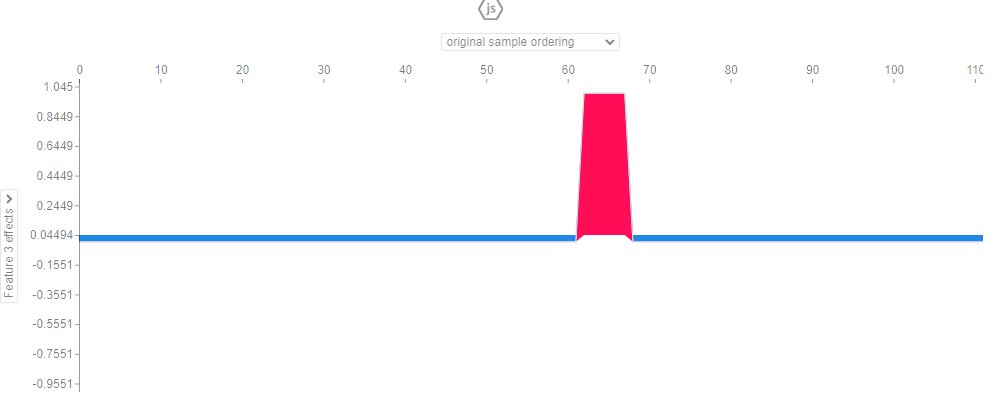

In [11]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image01.png")

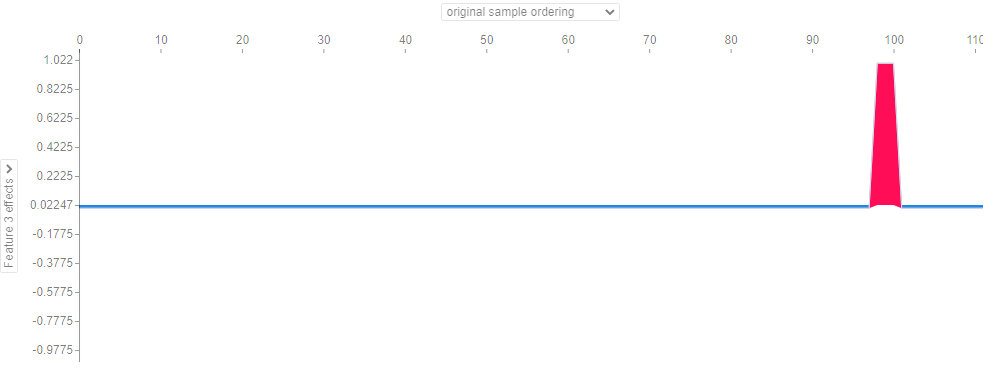

In [12]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image02.png")

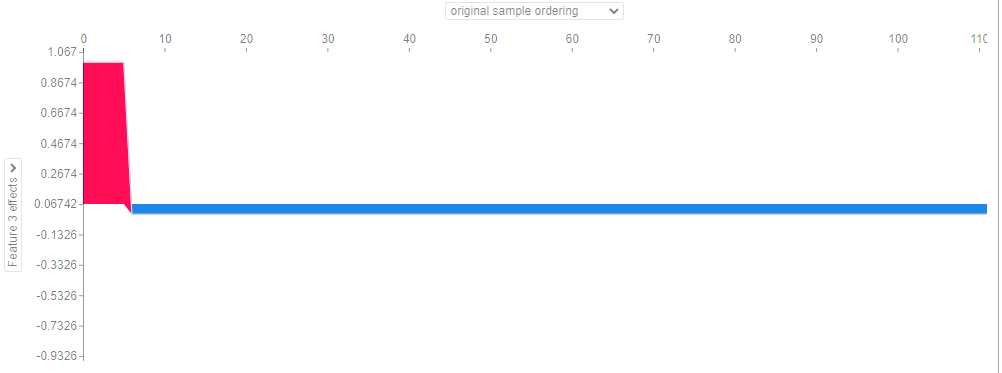

In [13]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image03.png")

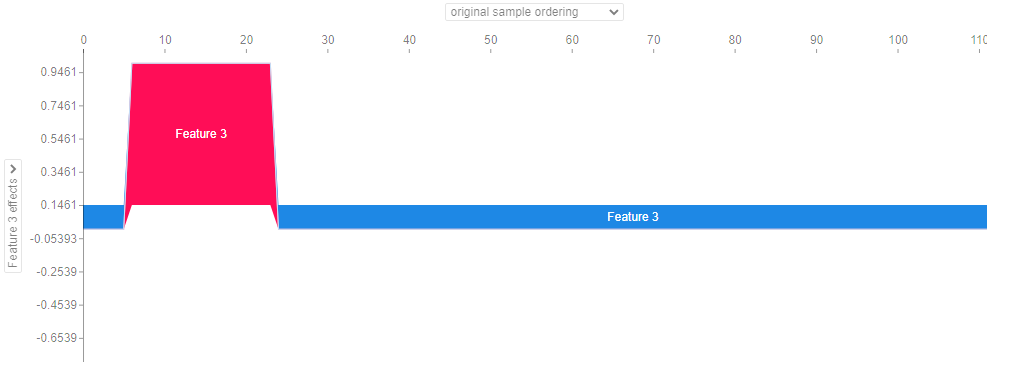

In [14]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image04.png")

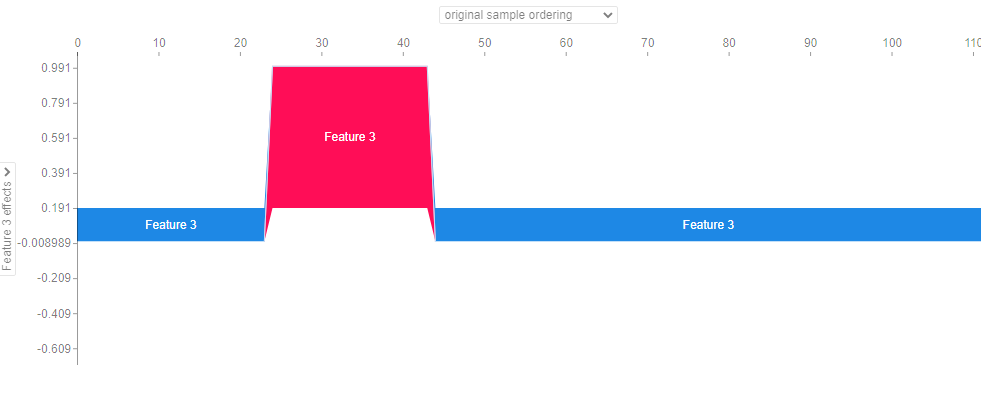

In [15]:
display.Image("https://journal-ai-php-logs.s3.eu-west-2.amazonaws.com/Privilege-Networks/image05.png")

**Result:**

# **It clearly indicates**

**High Importance: Health on Privilege and Data after that**

**Process: Service Based Maximisation**

**Analysis: Group Based**